### In this this seminar we will consider an example of [unsupervised learning](https://en.wikipedia.org/wiki/Unsupervised_learning) on graph. <br> It allows to obtain node embeddings without using any labels.

#### We're going to use so-called <font color='Blue'>triplet loss</font> from [GraphSAGE paper](https://arxiv.org/abs/1706.02216). <br> The idea is similar to the one in CV (you may want to check [arXiv:1412.6622](https://arxiv.org/abs/1412.6622), [arXiv:1503.03832](https://arxiv.org/abs/1503.03832), [arXiv:1601.05030](https://arxiv.org/abs/1601.05030)).

<div>
<img src="pictures/graph_triplet.png" width="400"/>
</div>

#### For each <font color='cornflowerblue'>Anchor</font> node we select a <font color='mediumseagreen'>Positive</font> node (obtained by random walk) and random <font color='red'>Negative</font> node. <br> Basically what we want is to obtain node embeddings $z$ that: <br> <ol> <li>Minimize the distance between an <font color='cornflowerblue'>Anchor (u)</font> and a <font color='mediumseagreen'>Positive (v)</font> </li> <li>Maximize the distance between an <font color='cornflowerblue'>Anchor (u)</font> and a <font color='red'>Negative ($v_n$)</font><br> </li>
</ol>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_cluster import random_walk

from torch_geometric.nn import SAGEConv
from torch_geometric.data import NeighborSampler as RawNeighborSampler
from torch_geometric.data import Data

import networkx as nx

In [2]:
data = torch.load('cora_dataset.pt')
data

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])

#### The model is heavily based on [PyTorch Geometric examples](https://github.com/rusty1s/pytorch_geometric/tree/master/examples) 

####  <u>Dataloader</u> <br>inherits *RawNeighborSampler* and returns <font color='Blue'>Triplets</font>: batch of anchors, positive examples and negative examples.

In [3]:
class NeighborSampler(RawNeighborSampler):
    def sample(self, batch):
        batch = torch.tensor(batch)  # indices of selected nodes
        
        row, col, _ = self.adj_t.coo()  # whole graph adjacency matrix (COO format)

        # For each node in `batch`, we sample a direct neighbor (as positive
        # example) and a random node (as negative example):
        
        pos_batch = random_walk(row, col, batch,
                                walk_length=1,
                                coalesced=False)[:, 1]  # [batch_size, ] 

        neg_batch = torch.randint(0, self.adj_t.size(1),
                                  (batch.numel(), ),
                                  dtype=torch.long)

        batch = torch.cat([batch, pos_batch, neg_batch], dim=0)
        
        # obtain neigbours for anchors, pos, negs  for aggregation
        return super(NeighborSampler, self).sample(batch)

#### example of sampling for 1 target node

In [4]:
train_loader = NeighborSampler(data.edge_index,
                               sizes=[10,10],
                               batch_size=1,
                               shuffle=True,
                               num_nodes=data.num_nodes,
                               num_workers=0)

In [5]:
# adjacency matrix
train_loader.adj_t

SparseTensor(row=tensor([   0,    0,    0,  ..., 2707, 2707, 2707]),
             col=tensor([ 633, 1862, 2582,  ...,  598, 1473, 2706]),
             val=tensor([ 2569,  7565, 10306,  ...,  2461,  5840, 10551]),
             size=(2708, 2708), nnz=10556, density=0.14%)

In [6]:
first_iter = next(iter(train_loader))
first_iter

(3,
 tensor([ 641, 2704, 1309,   61, 1338,  415,   88, 1677, 2102,  995, 1882, 2103,
         2178,  490, 1741, 2015, 1080, 1416, 2162, 2312, 1912, 2385,  966, 1644,
          300,  204, 1843, 1847,  851, 2182, 2013,  498,  130, 2010,  696, 2011,
          815,  191, 1908,  514,  516,  661,   76,  737, 1979, 2024]),
 [EdgeIndex(edge_index=tensor([[ 1,  0,  3,  4,  5,  6,  7,  8, 12, 13, 14, 15,  2, 16, 17, 18, 19,  2,
           20, 21,  2,  6, 22, 23, 24, 25, 26, 27, 28, 29, 24, 27, 28, 30, 31, 32,
           33, 34, 35, 36,  2,  5,  6, 37, 38,  2, 20, 21,  2, 20, 21,  2,  6, 39,
           40, 41,  2, 20, 21,  2,  5,  6, 42, 43, 44, 45],
          [ 0,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,
            4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,
            6,  6,  6,  6,  7,  7,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10,
           10, 10, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12]]), e_id=tensor([10546,  2592,   234,  5192, 

In [7]:
# unpack items
bs, n_id, adjs = first_iter

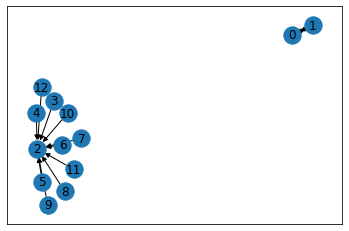

In [8]:
from torch_geometric.utils.convert import to_networkx
G = to_networkx(Data(edge_index=adjs[-1].edge_index))
nx.draw_networkx(G)

#### <u>Class for GraphSAGE Unsupervised model</u>

In [9]:
train_loader = NeighborSampler(data.edge_index,
                               sizes=[-1,-1],
                               batch_size=4096,
                               shuffle=True,
                               num_nodes=data.num_nodes,
                               num_workers=0)

In [10]:
class SAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers):
        super(SAGE, self).__init__()
        
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        
        for i in range(num_layers):
            in_channels = in_channels if i == 0 else hidden_channels
            self.convs.append(SAGEConv(in_channels, hidden_channels))

    def forward(self, x, adjs):
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]  # Target nodes are always placed first.
            x = self.convs[i]((x, x_target), edge_index)
            
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
                
        return x

    # forward for the whole graph
    def full_forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

#### <u>Initialize model</u>

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SAGE(data.num_node_features, hidden_channels=64, num_layers=2)
model = model.to(device)

x, edge_index = data.x.to(device), data.edge_index.to(device)

In [12]:
#number of parameters
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

191744

#### <u>Training Loop</u>

In [13]:
def train():
    model.train()

    total_loss = 0
    for batch_size, n_id, adjs in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        adjs = [adj.to(device) for adj in adjs]
        optimizer.zero_grad()

        # propagate messages for anchor, positive and negative nodes
        out = model(x[n_id], adjs) 
        out, pos_out, neg_out = out.split(out.size(0) // 3, dim=0)

        pos_loss = F.logsigmoid((out * pos_out).sum(-1)).mean()  # element-wise product + sum <=> scalar products
        neg_loss = F.logsigmoid(-(out * neg_out).sum(-1)).mean()
        loss = -pos_loss - neg_loss
        
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * out.size(0)

    return total_loss / data.num_nodes

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1,100):
    loss = train()
    
    if epoch % 5 == 0:
        print(f'Epoch: {epoch}, Loss: {loss:.4f}')

Epoch: 5, Loss: 1.4003
Epoch: 10, Loss: 1.3361
Epoch: 15, Loss: 1.2760
Epoch: 20, Loss: 1.2020
Epoch: 25, Loss: 1.1920
Epoch: 30, Loss: 1.1409
Epoch: 35, Loss: 1.1306
Epoch: 40, Loss: 1.1335
Epoch: 45, Loss: 1.0742
Epoch: 50, Loss: 1.0841
Epoch: 55, Loss: 1.0692
Epoch: 60, Loss: 1.0435
Epoch: 65, Loss: 1.0983
Epoch: 70, Loss: 1.0696
Epoch: 75, Loss: 1.0193
Epoch: 80, Loss: 1.0576
Epoch: 85, Loss: 1.0372
Epoch: 90, Loss: 1.0374
Epoch: 95, Loss: 1.0387


#### <u>Extract Embeddings</u>

In [15]:
with torch.no_grad():
    model.eval()
    out = model.full_forward(x, edge_index).cpu()

In [16]:
out.shape

torch.Size([2708, 64])

In [17]:
out

tensor([[-0.0100,  0.1511, -0.1368,  ..., -0.0118,  0.5012, -0.1540],
        [-0.1761,  0.4129,  0.1353,  ..., -0.2776,  0.1487,  0.0879],
        [-0.0446,  0.2935,  0.1294,  ..., -0.1969,  0.0468,  0.0401],
        ...,
        [ 0.2623, -0.1288,  0.1677,  ..., -0.2622, -0.0285,  0.0402],
        [ 0.1467,  0.0163,  0.0266,  ...,  0.1113,  0.2574, -0.1996],
        [ 0.1602,  0.0415,  0.1557,  ...,  0.1464,  0.1813, -0.1967]])

#### <u>Visualize Embeddings</u> <br> We use [UMAP](https://umap-learn.readthedocs.io/en/latest/index.html) to project embeddings to lower dimension.

In [18]:
import umap
reducer = umap.UMAP(n_neighbors=5, min_dist=0.4)

In [19]:
embeddings = reducer.fit_transform(out)
embeddings.shape

(2708, 2)

In [20]:
embeddings

array([[ 3.2018957, -1.1615559],
       [ 9.216026 ,  5.2972884],
       [ 8.741129 ,  5.87768  ],
       ...,
       [10.199613 , -3.6426368],
       [ 3.2244568,  6.8819866],
       [ 2.6782923,  6.3356433]], dtype=float32)

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

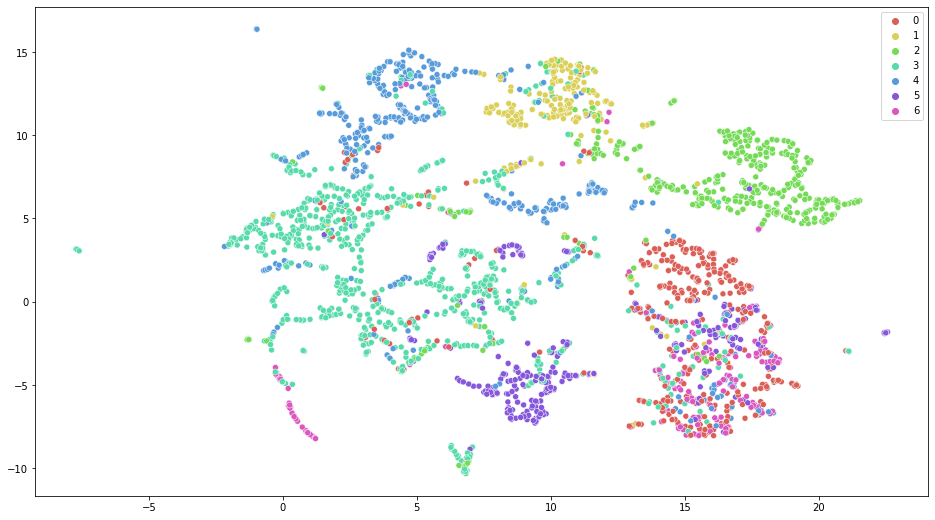

In [24]:
plt.figure(figsize=(16,9))
sns.scatterplot(x=embeddings[:, 0], y=embeddings[:,1], hue=data.y, palette=sns.color_palette("hls", 7))
plt.show()